In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset, Image

# Prepare data

In [2]:
def show_image(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()


def show_images(images, n=2):
    fig, axs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        axs[i].imshow(images[i])
        axs[i].axis("off")
    plt.show()

In [3]:
dataset = load_dataset(
    "mattymchen/celeba-hq", cache_dir="./data/train", split="train", num_proc=4
)
dataset_test = load_dataset(
    "mattymchen/celeba-hq",
    cache_dir="./data/validation",
    split="validation",
    num_proc=4,
)

In [4]:
dataset = dataset.cast_column("image", Image(decode=True))
dataset_test = dataset_test.cast_column("image", Image(decode=True))

In [5]:
print(dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x160F3C4F0>, 'label': 0}


In [6]:
from torchvision.transforms import Compose, ColorJitter, ToTensor

jitter = Compose(
    [
        ToTensor(),
    ]
)

In [7]:
def transforms(examples):
    examples["input"] = [
        jitter(image.convert("RGB").resize((512 // 4, 512 // 4)))
        for image in examples["image"]
    ]
    examples["target"] = [
        jitter(image.convert("RGB").resize((512, 512))) for image in examples["image"]
    ]
    return examples

In [8]:
dataset.set_transform(transforms)
dataset_test.set_transform(transforms)

torch.Size([3, 128, 128])


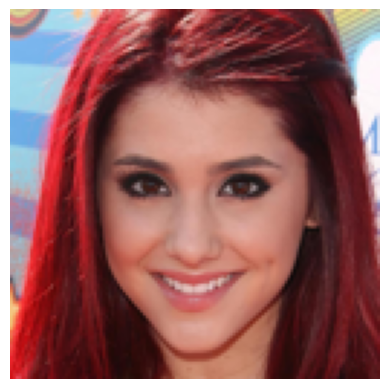

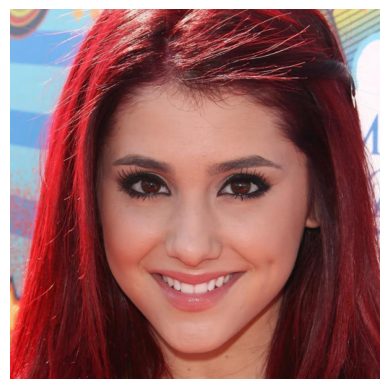

In [9]:
img_index = 15
print(dataset[img_index]["input"].shape)
show_image(dataset[img_index]["input"].permute(1, 2, 0))
show_image(dataset[img_index]["target"].permute(1, 2, 0))

In [10]:
from torch.utils.data import Dataset


class CelebHQDataset(Dataset):
    def __init__(self, dataset, length=None):
        self.dataset = dataset
        self.length = length

    def __len__(self):
        if self.length:
            return self.length
        return len(self.dataset)

    def __getitem__(self, idx):
        return {
            "input": self.dataset[idx]["input"],
            "target": self.dataset[idx]["target"],
        }

In [11]:
from torch.utils.data import DataLoader

train_dataset = CelebHQDataset(dataset, 2000)
val_dataset = CelebHQDataset(dataset_test, 200)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
for i in train_dataloader:
    print(i["input"].shape)
    print(i["target"].shape)
    break

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 512, 512])


In [23]:
from model import espcn_x4

model = espcn_x4(in_channels=3, out_channels=3, channels=64)

In [24]:
model

ESPCN(
  (feature_maps): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU6()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU6()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU6()
  )
  (sub_pixel): Sequential(
    (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PixelShuffle(upscale_factor=4)
  )
)

In [29]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.image import PeakSignalNoiseRatio
import torch


class ESPCN(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = torch.nn.MSELoss(reduction="sum")
        self.psnr = PeakSignalNoiseRatio()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["input"], batch["target"]
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log(
            "train_loss", loss, logger=True, on_step=True, on_epoch=True, prog_bar=True
        )
        self.log(
            "train_psnr",
            self.psnr(y_hat, y),
            logger=True,
            on_epoch=True,
            prog_bar=True,
        )
        return loss
    
    # def on_train_epoch_end(self):
    #     sch = self.lr_schedulers()
    # 
    #     # If the selected scheduler is a ReduceLROnPlateau scheduler.
    #     if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau):
    #         sch.step(self.trainer.callback_metrics["loss"])

    def validation_step(self, batch, batch_idx):
        x, y = batch["input"], batch["target"]
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log(
            "val_loss", loss, logger=True, on_step=True, on_epoch=True, prog_bar=True
        )
        self.log(
            "val_psnr",
            self.psnr(y_hat, y),
            logger=True,
            on_epoch=True,
            prog_bar=True,
        )
        if batch_idx == 0:
            show_images(
                [
                    y[0].permute(1, 2, 0).cpu().numpy(),
                    y_hat[0].permute(1, 2, 0).cpu().numpy(),
                ]
            )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler":torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'), "monitor": "val_loss"}}

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | ESPCN                | 74.1 K
1 | loss  | MSELoss              | 0     
2 | psnr  | PeakSignalNoiseRatio | 0     
-----------------------------------------------
74.1 K    Trainable params
0         Non-trainable params
74.1 K    Total params
0.297     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

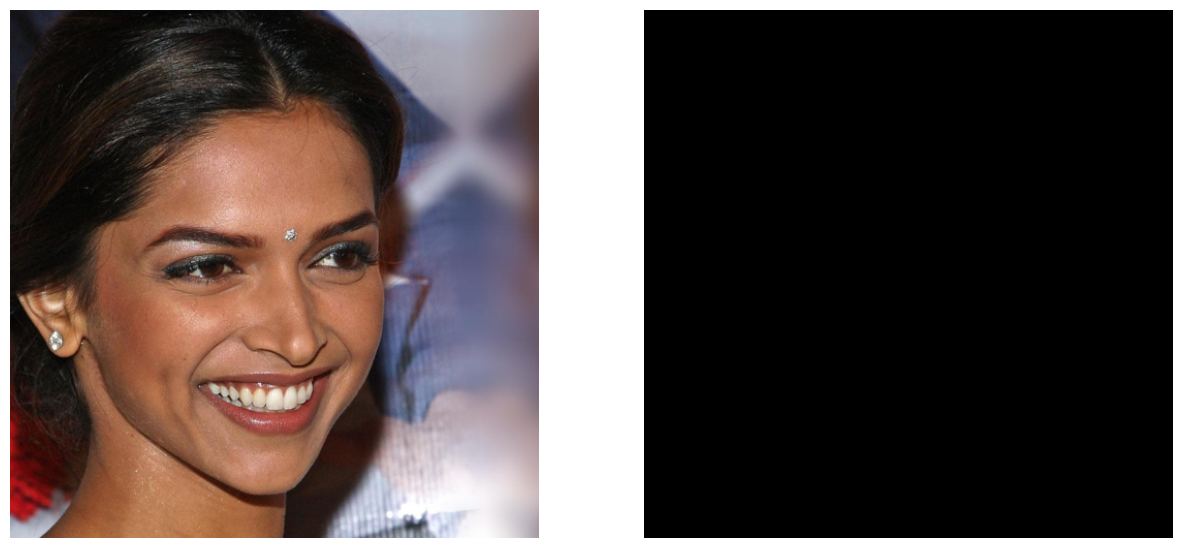

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

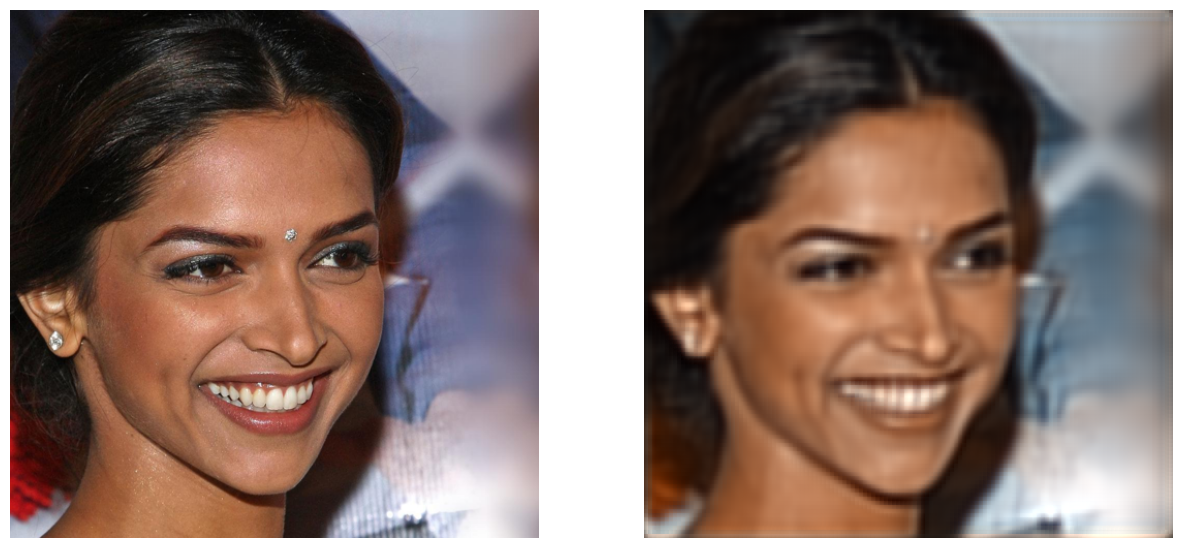

In [30]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./checkpoints",
    filename="espcn-{epoch:02d}-{val_loss:.2f}-{val_psnr:.2f}",
    save_top_k=3,
    mode="min",
)

model = espcn_x4(in_channels=3, out_channels=3, channels=64)
train_model = ESPCN(model)
trainer = pl.Trainer(accelerator="mps", max_epochs=100, callbacks=[checkpoint_callback])
trainer.fit(train_model, train_dataloader, val_dataloader)